In [1]:
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import lightning.pytorch as pl
import os

/usr/local/lib/python3.11/site-packages/pytorch_forecasting/models/base/_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
data_dir = "/app/bucket/data/processed_data"
filedir = os.path.join(data_dir, "prep_D_data.csv")
data_df = pd.read_csv(filedir)
data_df['ds'] = pd.to_datetime(data_df['ds'], format='%Y-%m-%d')
data_df.set_index('ds', inplace=True)
data_df = data_df.sort_index()

data_df['time_idx'] = range(len(data_df))
data_df['group'] = 'SPY'
data_df['day_of_week'] = data_df.index.dayofweek.astype(str)
data_df['week_of_year'] = data_df.index.isocalendar().week.astype(str)
print(data_df.shape)
data_df.head()

(3868, 18)


,spy_close,SMA_60,SMA_120,BBL_20,BBM_20,BBU_20,BBB_20,BBP_20,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,spy_volume_lag_1D,CLI_lag_1MS,time_idx,group,day_of_week,week_of_year
ds,,,,,,,,,,,,,,,,,,
2010-06-24,107.42,114.281667,113.377000,105.188016,109.3740,113.559984,7.654440,0.266602,-0.703357,0.184935,-0.888292,40.495411,254639900.0,99.71648,0,SPY,3,25
2010-06-25,107.87,114.129500,113.331500,105.045443,109.2295,113.413557,7.661039,0.337538,-0.800797,0.069997,-0.870793,42.094856,268523600.0,99.71648,1,SPY,4,25
2010-06-28,107.53,113.958333,113.280667,104.886076,109.1375,113.388924,7.790950,0.310946,-0.895135,-0.019473,-0.875662,41.193901,238726500.0,99.71648,2,SPY,0,26
2010-06-29,104.21,113.715833,113.201500,104.225322,108.9715,113.717678,8.710860,-0.001614,-1.223688,-0.278421,-0.945267,33.625754,169218600.0,99.71648,3,SPY,1,26
2010-06-30,103.22,113.452167,113.110083,103.270937,108.6160,113.961063,9.842129,-0.004765,-1.546132,-0.480692,-1.065440,31.752420,373649500.0,99.71648,4,SPY,2,26


In [3]:
# 마지막 120일을 검증 데이터로 분리
validation_cut_off = data_df['time_idx'].max() - 120

training_data = TimeSeriesDataSet(
    data_df[lambda x: x.time_idx <= validation_cut_off], 
    time_idx="time_idx",
    target="spy_close",
    group_ids=["group"],
    max_encoder_length=60, 
    max_prediction_length=10, 
    
    # [변수 타입 정의]
    time_varying_known_categoricals=["day_of_week", "week_of_year", "group"],
    time_varying_known_reals=["time_idx"], 
    time_varying_unknown_reals=['spy_close', 'SMA_60', 'SMA_120', 'BBL_20', 'BBM_20', 'BBU_20',
       'BBB_20', 'BBP_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
       'RSI_14', 'spy_volume_lag_1D', 'CLI_lag_1MS'], # 예측 대상은 모르는 변수
    
    # [정규화]
    target_normalizer=GroupNormalizer(groups=["group"], transformation="softplus"),
    add_target_scales=True,
    add_encoder_length=True,
)

# 데이터 로더 생성
batch_size = 64
train_dataloader = training_data.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

In [4]:
# 1. TFT 모델 정의
tft = TemporalFusionTransformer.from_dataset(
    training_data,
    loss=QuantileLoss(), # 표준 손실 함수
    hidden_size=16,
    attention_head_size=1,
)

# 2. 학습 실행
trainer = pl.Trainer(max_epochs=10, accelerator="auto")
trainer.fit(tft, train_dataloaders=train_dataloader)

/usr/local/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dep

Epoch 1:   0%|          | 0/57 [00:00<?, ?it/s, v_num=3, train_loss_step=25.80, train_loss_epoch=52.80]         

/usr/local/lib/python3.11/site-packages/lightning/pytorch/loops/training_epoch_loop.py:492: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 9: 100%|██████████| 57/57 [00:14<00:00,  3.88it/s, v_num=3, train_loss_step=4.110, train_loss_epoch=3.920]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s, v_num=3, train_loss_step=4.110, train_loss_epoch=3.920]


In [15]:
start_idx = validation_cut_off - training_data.max_encoder_length
end_idx = validation_cut_off + training_data.max_prediction_length
first_valid_df = data_df.iloc[start_idx:end_idx].copy()
first_valid_data = TimeSeriesDataSet.from_dataset(training_data, first_valid_df, predict=True, stop_randomization=True)
first_valid_dataloader = first_valid_data.to_dataloader(train=False, batch_size=1, num_workers=0)

In [30]:
raw_predictions = tft.predict(first_valid_dataloader, return_x=True, mode="raw", trainer_kwargs=dict(accelerator="cpu"))

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


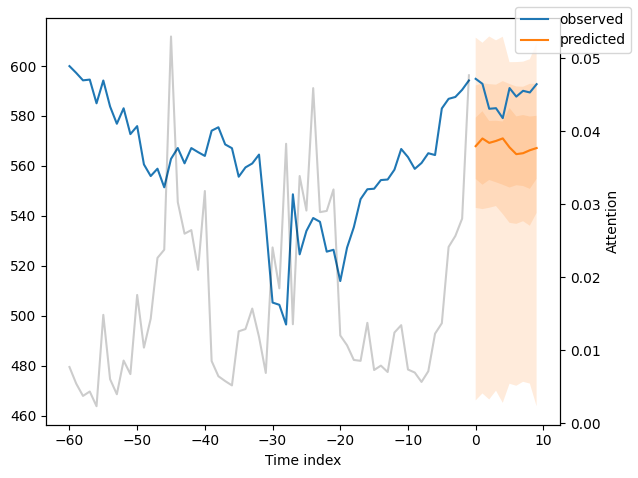

In [33]:
import matplotlib.pyplot as plt

# *raw_predictions는 이전 단계에서 tft.predict()를 통해 얻은 결과입니다.*

# 1. 시각화 함수 호출
# plot_prediction은 x (입력 데이터)와 output (예측 결과)를 모두 필요로 합니다.
fig = tft.plot_prediction(
    raw_predictions.x, 
    raw_predictions.output,
    idx=0
    # idx=0, # 단일 예측 포인트를 시각화하므로 첫 번째 인덱스(0)를 지정
    # add_loss_to_title=True # 선택 사항: 제목에 손실 값 추가
)

# 2. 그래프 출력
plt.show()